<a href="https://colab.research.google.com/github/praveenkumaresan/image-classification/blob/main/pk_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom CNN

In [32]:
import os
import shutil

# Path to the cache directory used by kagglehub
cache_directory = "/root/.cache/kagglehub"

# Check if the cache directory exists and delete it
if os.path.exists(cache_directory):
    shutil.rmtree(cache_directory)
    print("Cache cleared successfully.")
else:
    print("Cache directory not found.")


Cache cleared successfully.


In [39]:
import os
import kagglehub

# Download the dataset using kagglehub
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")
print("Path to dataset files:", path)

# Function to print the directory structure
def print_directory_structure(directory):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        # for file in files:
        #     print(f"{sub_indent}{file}")

# Print the directory structure of the entire dataset
print("\nDirectory structure of the dataset:")
print_directory_structure(path)


Path to dataset files: /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1

Directory structure of the dataset:
1/
    train/
    test/
    flower_images/
        Tulip/
        Sunflower/
        Lotus/
        Orchid/
        Lilly/
    validation/


#### Split the dataset into test, training and validation

In [40]:
import os
import shutil
import random
import kagglehub

# Download the dataset using kagglehub
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")
print("Path to dataset files:", path)

# Set the path to the flower_images directory
flower_images_dir = os.path.join(path, "flower_images")
base_dir = path

# Automatically create paths for train, validation, and test directories
train_directory = os.path.join(base_dir, "train")
validation_directory = os.path.join(base_dir, "validation")
test_directory = os.path.join(base_dir, "test")

# Create directories for training, validation, and test sets
os.makedirs(train_directory, exist_ok=True)
os.makedirs(validation_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

# Iterate over each class folder in flower_images
for class_name in os.listdir(flower_images_dir):
    class_dir = os.path.join(flower_images_dir, class_name)

    if os.path.isdir(class_dir):
        # Get a list of all image files in this class
        images = [file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)  # Shuffle the images randomly

        # Calculate the number of images for each split
        total_images = len(images)
        train_count = int(total_images * 0.7)
        validation_count = int(total_images * 0.2)

        # Create class directories in train, validation, and test folders
        os.makedirs(os.path.join(train_directory, class_name), exist_ok=True)
        os.makedirs(os.path.join(validation_directory, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_directory, class_name), exist_ok=True)

        # Split and copy images to the respective directories
        for i, image in enumerate(images):
            src_path = os.path.join(class_dir, image)
            if i < train_count:
                dest_path = os.path.join(train_directory, class_name, image)
            elif i < train_count + validation_count:
                dest_path = os.path.join(validation_directory, class_name, image)
            else:
                dest_path = os.path.join(test_directory, class_name, image)

            shutil.copy(src_path, dest_path)

# Function to count the number of images in a directory
def count_images_in_directory(directory):
    count = 0
    for root, _, files in os.walk(directory):
        count += len([file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return count

# Print the number of images in each directory
print("\nNumber of images in each directory:")
print("Train Directory:", count_images_in_directory(train_directory))
print("Validation Directory:", count_images_in_directory(validation_directory))
print("Test Directory:", count_images_in_directory(test_directory))


Path to dataset files: /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1

Number of images in each directory:
Train Directory: 3499
Validation Directory: 999
Test Directory: 501


#### Install necessary

In [9]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models

#### Load and Preprocess the Data

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_directory = train_directory
print('train ', train_directory)
validation_directory = validation_directory
print('validation ', validation_directory)

# Create data generators for loading and augmenting images
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values between 0 and 1
    rotation_range=20,  # Data augmentation: rotate images
    width_shift_range=0.2,  # Data augmentation: shift images horizontally
    height_shift_range=0.2,  # Data augmentation: shift images vertically
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill strategy for augmented images
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(150, 150),  # Resize images to a fixed size
    batch_size=32,
    class_mode='categorical'  # Use 'binary' if you have only two classes
)

validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


train  /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1/train
validation  /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1/validation
Found 3499 images belonging to 5 classes.
Found 999 images belonging to 5 classes.


#### Define Custom CNN Model

In [42]:
model = models.Sequential()

# First Convolutional Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output and add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))  # Output layer for 5 classes


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use 'binary_crossentropy' for binary classification
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    #epochs=10, >> performance issues
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.6537 - loss: 0.8969 - val_accuracy: 0.7107 - val_loss: 0.7873
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 924us/step - accuracy: 0.7188 - loss: 0.7601 - val_accuracy: 0.5714 - val_loss: 0.8700
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6745 - loss: 0.8293 - val_accuracy: 0.7228 - val_loss: 0.7355
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5312 - loss: 1.0097 - val_accuracy: 0.8571 - val_loss: 0.5831
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.6878 - loss: 0.8010 - val_accuracy: 0.7137 - val_loss: 0.7876


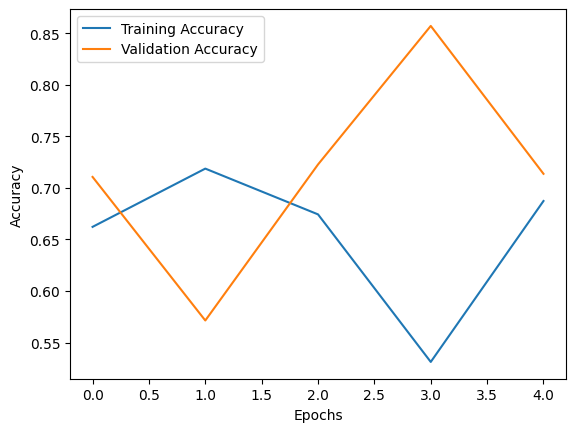

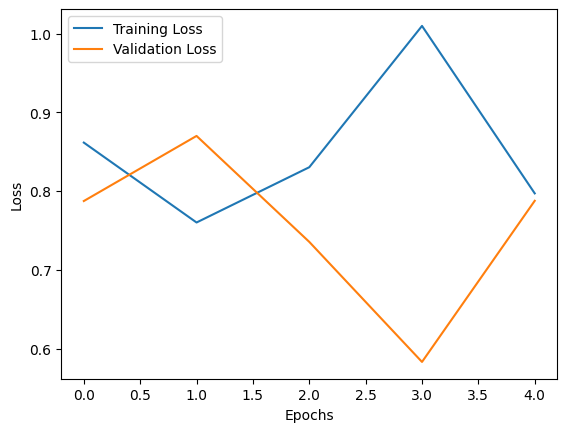

In [48]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
